March: Images for PO Seminar presentation - upwelling depth slices animations. 

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [3]:
def get_vars(dirname, fname, maskname, dep_ind):
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    time_ind = 24*4
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][:time_ind, dep_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][:time_ind, 0, 0] 
        nav_lat = dsT.variables['nav_lat'][y, x]
        nav_lon = dsT.variables['nav_lon'][y, x]
        
    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, dep_ind, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    interval = 8
    vosaline = vosaline[::interval, ...]
    sozotaux = sozotaux[::interval]
    tmask = tmask[::interval, ...]
    
    return vosaline, sozotaux, deptht, tmask, nav_lat, nav_lon

In [4]:
def get_deptht_ind(vosaline, vosaline_ref_profile):
    
    # trace back the deptht_ind where this_vosaline occured the vosaline_ref     
    deptht_ind = np.full_like(vosaline, np.nan, dtype=np.int)
    for t in range(deptht_ind.shape[-3]):
        print(t)
        for y in range(deptht_ind.shape[-2]):
            for x in range(deptht_ind.shape[-1]):
                this_vosaline = vosaline[t, y, x]
                deptht_ind[t, y, x] = min(range(len(vosaline_ref_profile)), key=lambda i: abs(vosaline_ref_profile[i]-this_vosaline))

    print(deptht_ind.shape, type(deptht_ind))

    return deptht_ind

In [5]:
def get_deptht_m(deptht, deptht_ind, tmask_new):

    # get deptht for deptht_ind of origin
    deptht_m0 = deptht[deptht_ind]
    deptht_m = np.ma.array(deptht_m0, mask=1 - tmask_new)

    print(deptht_m.shape, type(deptht_m))
    
    return deptht_m

In [6]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

In [7]:
wind = 'half'

In [8]:
dep_ind = 11

In [9]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_' + wind + '/'
fname = "1_MCKNZ_1h_20170101_201701*"
maskname = '1_mesh_mask.nc'
vosaline_i, sozotaux_i, deptht_i, tmask_i, nav_lat_i, nav_lon_i = get_vars(dirname, fname, maskname, dep_ind)

In [10]:
vosaline_i.shape, sozotaux_i.shape, tmask_i.shape

((12, 272, 242), (12,), (12, 1, 272, 242))

In [11]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_' + wind + '/'
fname = "MCKNZ_1h_20170101_201701*"
maskname = 'mesh_mask.nc'
vosalinep_i, sozotauxp_i, depthtp_i, tmaskp_i, nav_latp_i, nav_lonp_i = get_vars(dirname, fname, maskname, dep_ind)

In [12]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_' + wind + '/'
fname = "1_MCKNZ_1h_20170101_201701*"
maskname = '1_mesh_mask.nc'
vosaline_r, sozotaux_r, deptht_r, tmask_r, nav_lat_r, nav_lon_r = get_vars(dirname, fname, maskname, dep_ind)

In [13]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_' + wind + '/'
fname = "MCKNZ_1h_20170101_201701*"
maskname = 'mesh_mask.nc'
vosalinep_r, sozotauxp_r, depthtp_r, tmaskp_r, nav_latp_r, nav_lonp_r = get_vars(dirname, fname, maskname, dep_ind)

In [14]:
deptht_ind_i = get_deptht_ind(vosaline_i, vosaline_ref_profile)
deptht_m_i = get_deptht_m(deptht_i, deptht_ind_i, tmask_i)

deptht_indp_i = get_deptht_ind(vosalinep_i, vosaline_ref_profile)
deptht_mp_i = get_deptht_m(depthtp_i, deptht_indp_i, tmaskp_i)

deptht_ind_r = get_deptht_ind(vosaline_r, vosaline_ref_profile)
deptht_m_r = get_deptht_m(deptht_r, deptht_ind_r, tmask_r)

deptht_indp_r = get_deptht_ind(vosalinep_r, vosaline_ref_profile)
deptht_mp_r = get_deptht_m(depthtp_r, deptht_indp_r, tmaskp_r)

0
1
2
3
4
5
6
7
8
9
10
11
(12, 272, 242) <class 'numpy.ma.core.MaskedArray'>
(12, 272, 242) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
(12, 188, 253) <class 'numpy.ma.core.MaskedArray'>
(12, 188, 253) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
(12, 272, 182) <class 'numpy.ma.core.MaskedArray'>
(12, 272, 182) <class 'numpy.ma.core.MaskedArray'>
0
1
2
3
4
5
6
7
8
9
10
11
(12, 188, 253) <class 'numpy.ma.core.MaskedArray'>
(12, 188, 253) <class 'numpy.ma.core.MaskedArray'>


In [15]:
def plot_originaldepth(fig, ax, deptht_m, deptht_mp, deptht, dep_ind, n, kind, nav_lat, nav_latp, nav_lon, nav_lonp):
    
    ax.cla()
    
    # child
    plot_array = deptht_m[n, :, :]
    # parent
    plot_arrayp = deptht_mp[n, :, :]
    
    midpoint = deptht[dep_ind]
    vmin, vmax = 0, midpoint*2
    cmap, norm = cmo.cm.delta_r, MidpointNormalize(midpoint=midpoint)
    cmap.set_bad('silver')
    
    y_top = 145
    x_top = 50
    x_half= x_top/2
    x_left = x_top + x_half
    x_right = x_top - x_half
    
    if kind == 'ideal':
        levels = [75, 100, 109, 118, 126, 170]#91 , 153
        # parent
        pp = ax.pcolormesh(nav_lonp[:y_top, x_top:-x_top], nav_latp[:y_top, x_top:-x_top], plot_arrayp[:y_top, x_top:-x_top],
                           cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    elif kind == 'real':
        levels = [75, 100, 109, 118, 126]#91
        # parent
        pp = ax.pcolormesh(nav_lonp[:y_top, x_left:-x_right], nav_latp[:y_top, x_left:-x_right], plot_arrayp[:y_top, x_left:-x_right],
                           cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    
    # child
    pc = ax.pcolormesh(nav_lon, nav_lat, plot_array, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    
    if n == 0:
        axins = inset_axes(ax,
                        width="40%",  # width = 10% of parent_bbox width
                        height="5%",  # height : 50%
                        loc=2)
        axins.xaxis.set_ticks_position("bottom")

        cbar = fig.colorbar(pc, cax=axins, orientation='horizontal')#, pad=cpad, fraction=cbarf)
        cbar.set_label('depth [m]', fontsize=35, rotation=0, labelpad=3.0)
        tick_locator = ticker.MaxNLocator(nbins=4)
        cbar.locator = tick_locator
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=20)
        
    ax.tick_params(axis='both', which='both', labelsize=20)
    ax.set_title(str(n*8), fontsize=35)
    ax.set_ylabel('Latitude', fontsize=35)
    ax.set_xlabel('Longitude', fontsize=35)
    cs = ax.contour(nav_lon, nav_lat, plot_array, levels = levels, colors='k', alpha=0.7, lw=2)
    ax.clabel(cs, inline=1, fontsize=16, fmt='%1.f')
    w=1/math.cos(math.radians(70.0))
    ax.set_aspect(w)
    fig.tight_layout()

    return

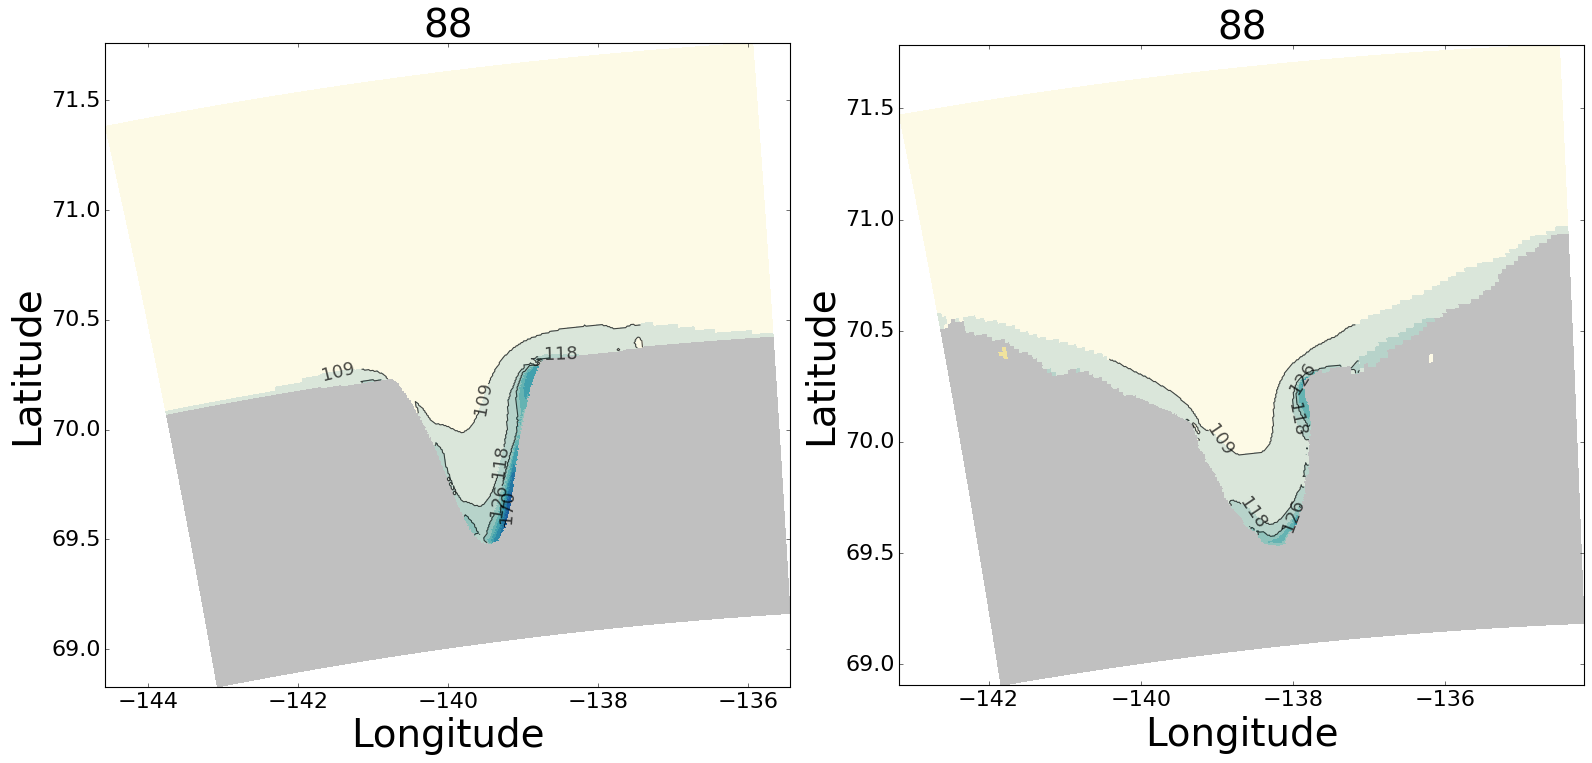

In [16]:
n = 11
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
plot_originaldepth(fig, ax1, deptht_m_i, deptht_mp_i, deptht_i, dep_ind, n, 'ideal',
                   nav_lat_i, nav_latp_i, nav_lon_i, nav_lonp_i)
plot_originaldepth(fig, ax2, deptht_m_r, deptht_mp_r, deptht_r, dep_ind, n, 'real',
                   nav_lat_r, nav_latp_r, nav_lon_r, nav_lonp_r)

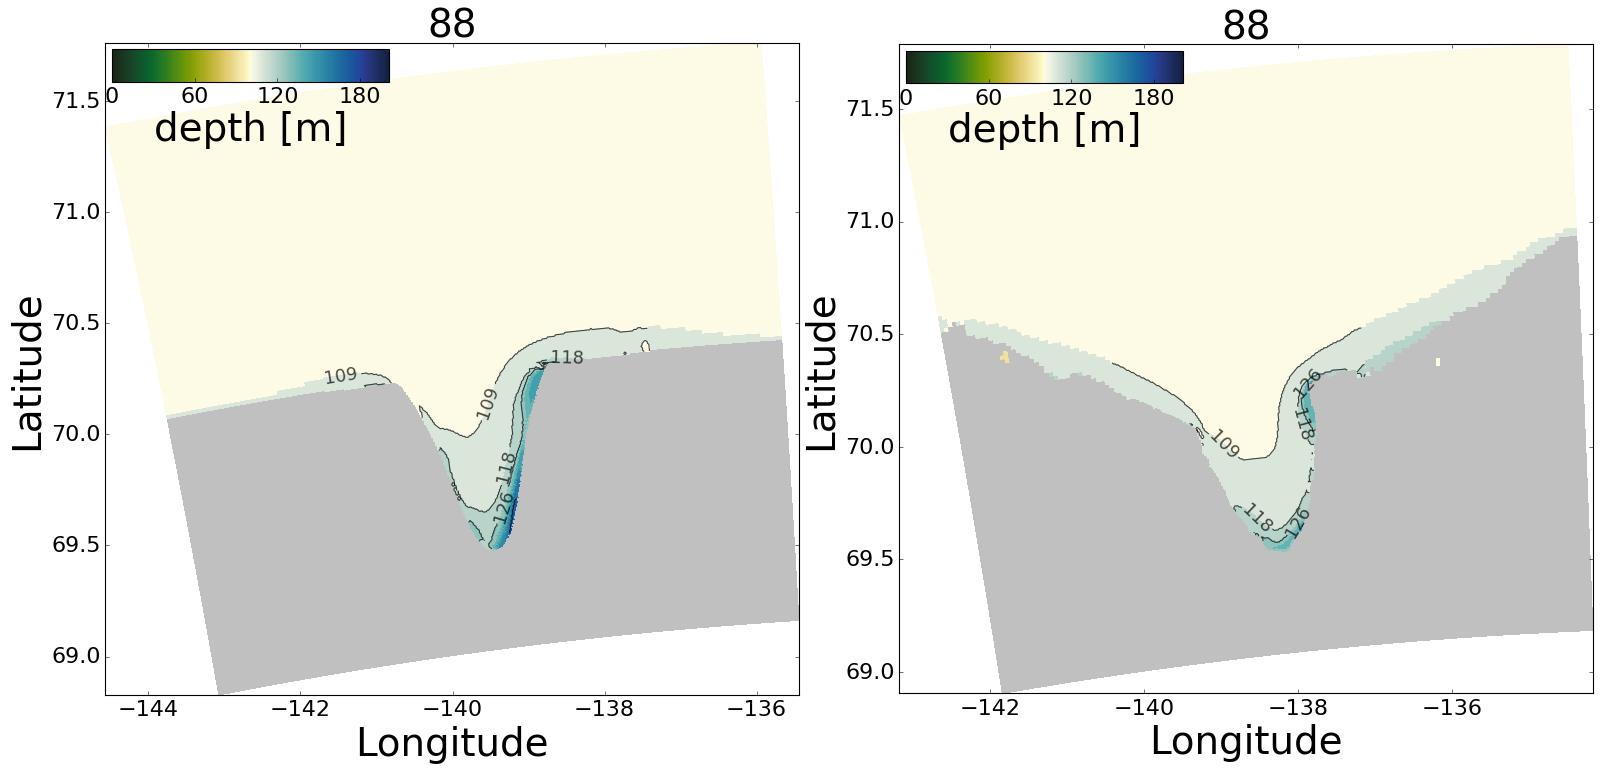

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

def init():
    return

def animate(n):
    plot_originaldepth(fig, ax1, deptht_m_i, deptht_mp_i, deptht_i, dep_ind, n, 'ideal',
                   nav_lat_i, nav_latp_i, nav_lon_i, nav_lonp_i)
    plot_originaldepth(fig, ax2, deptht_m_r, deptht_mp_r, deptht_r, dep_ind, n, 'real',
                   nav_lat_r, nav_latp_r, nav_lon_r, nav_lonp_r)
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=12, repeat=False)
anim.save('anim_'+wind+'_upwell.mp4', writer=writer)